In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !pip install umap-learn
    !wandb login
    # !pip install umap-learn
    output.clear()
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
else:
    "Running local"

/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt
import numpy as np

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [4]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018'


dataset = SoundscapeData(root_path, audio_length=12, ext="wav", win_length=1028)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.3), len(dataset) - round(len(dataset)*0.3)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 3,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "AE",
    "win_length" : dataset.win_length
}

# torch.save(dataset_test, "temporal/dataset_test_ae_jaguas")
# torch.save(dataset_train, "temporal/dataset_train_ae_jaguas")
training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])


model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

In [ ]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'{run_name}_day_{time.day}_hour_{time.hour}.pkl')
torch.save(config,f'config_{run_name}_day_{time.day}_hour_{time.hour}.pth')

Output hidden; open in https://colab.research.google.com to view.

In [5]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'Models/AE_batch_size_14_num_hiddens_64__day_4_hour_1_epoch_3.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

[[[-0.00519217  0.00012822  0.00703395 ...  0.00292849  0.00342787
   -0.00274095]]]
[[[-0.13429415 -0.08973504 -0.03189832 ... -0.06628224 -0.06209988
   -0.1137648 ]]]


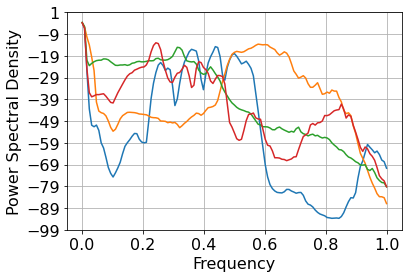

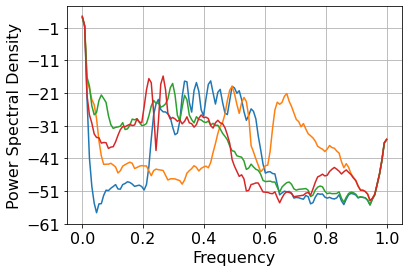

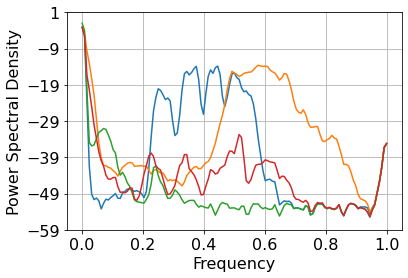

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

[[[-0.00519217  0.00012822  0.00703395 ...  0.00292849  0.00342787
   -0.00274095]]]
[[[-0.13429415 -0.08973504 -0.03189832 ... -0.06628224 -0.06209988
   -0.1137648 ]]]


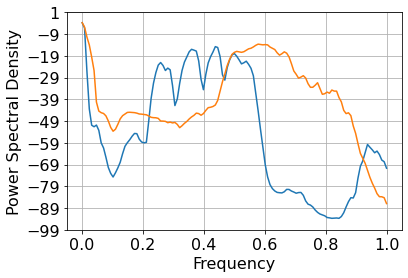

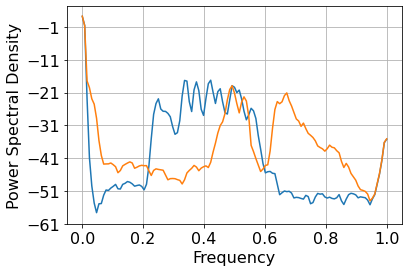

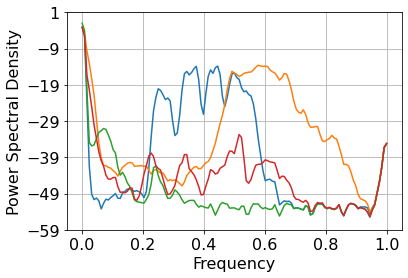

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


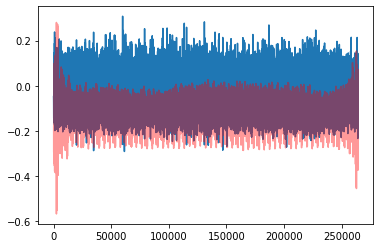

In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)

In [12]:
(1+1) % 1

0

id: 1 of 61
cuda
0.063658945
test1
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.063658945
Ya debio plotear


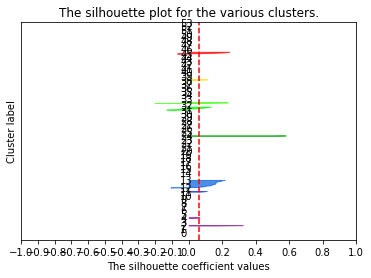

id: 2 of 61
cuda
0.088319406
test2
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.088319406
Ya debio plotear


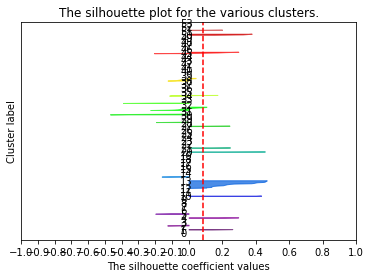

For n_clusters = 54 The average silhouette_score is : 0.088319406
Ya debio plotear


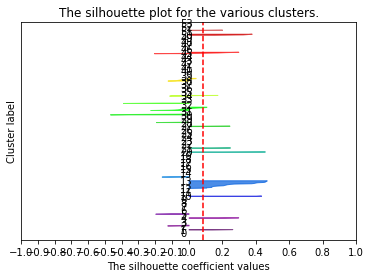

id: 3 of 61
cuda
0.1351681
test3
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.1351681
Ya debio plotear


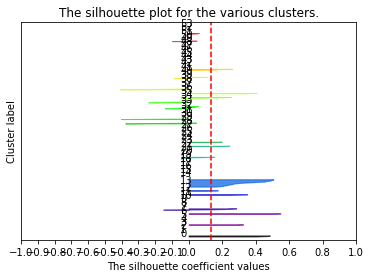

id: 4 of 61
cuda
0.085890025
test4
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.085890025
Ya debio plotear


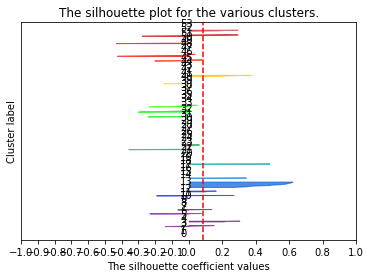

For n_clusters = 54 The average silhouette_score is : 0.085890025
Ya debio plotear


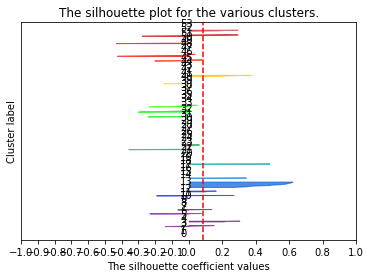

id: 5 of 61
cuda
0.16444199
test5
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.16444199
Ya debio plotear


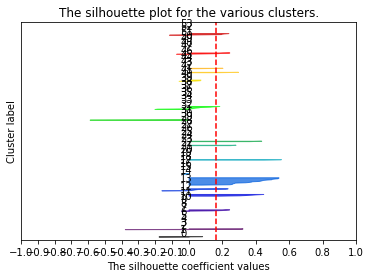

id: 6 of 61
cuda
0.15321606
test6
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.15321606
Ya debio plotear


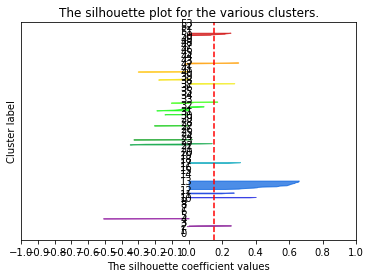

For n_clusters = 54 The average silhouette_score is : 0.15321606
Ya debio plotear


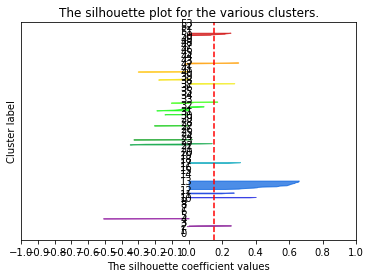

id: 7 of 61
cuda
-0.004335721
test7
nothing to plot
For n_clusters = 54 The average silhouette_score is : -0.004335721
Ya debio plotear


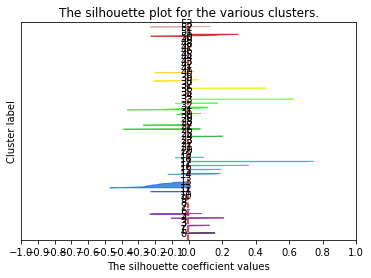

id: 8 of 61
cuda
0.05139562
test8
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.05139562
Ya debio plotear


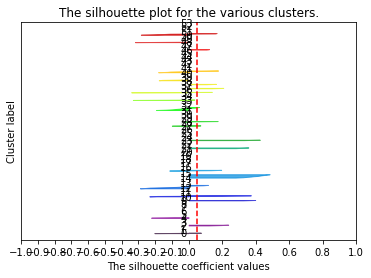

For n_clusters = 54 The average silhouette_score is : 0.05139562
Ya debio plotear


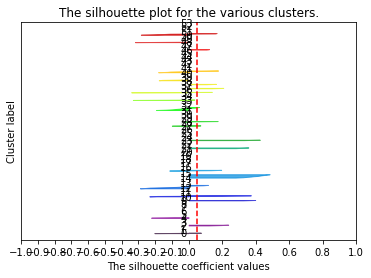

id: 9 of 61
cuda
0.040312562
test9
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.040312562
Ya debio plotear


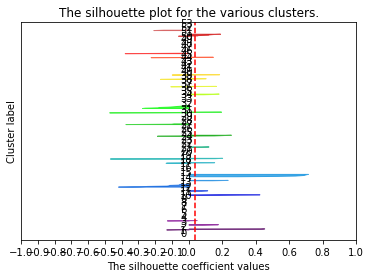

id: 10 of 61
cuda
0.069577195
test10
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.069577195
Ya debio plotear


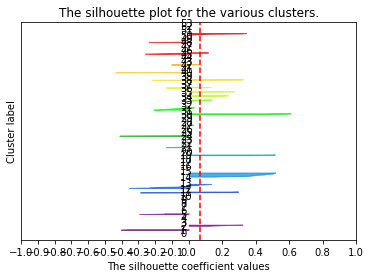

For n_clusters = 54 The average silhouette_score is : 0.069577195
Ya debio plotear


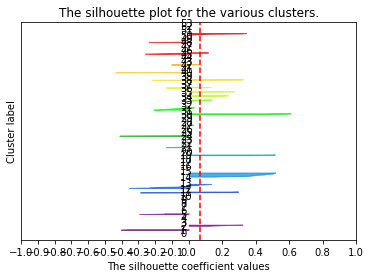

id: 11 of 61
cuda
0.07658903
test11
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.07658903
Ya debio plotear


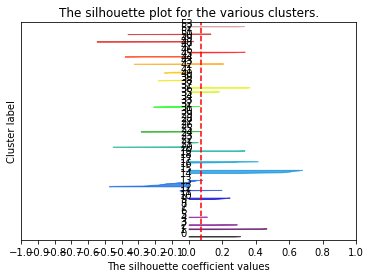

id: 12 of 61
cuda
0.07774671
test12
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.07774671
Ya debio plotear


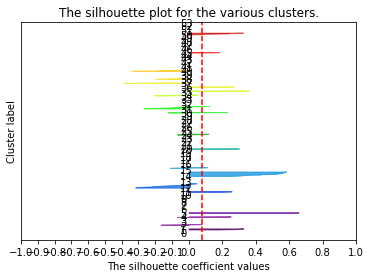

For n_clusters = 54 The average silhouette_score is : 0.07774671
Ya debio plotear


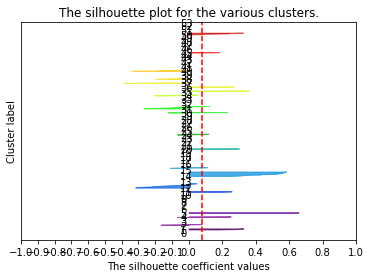

id: 13 of 61
cuda
0.019206012
test13
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.019206012
Ya debio plotear


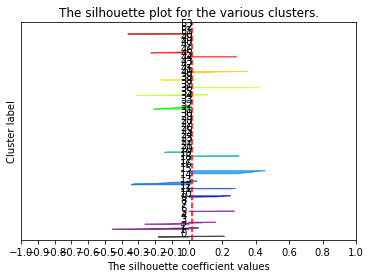

id: 14 of 61
cuda
0.010430176
test14
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.010430176
Ya debio plotear


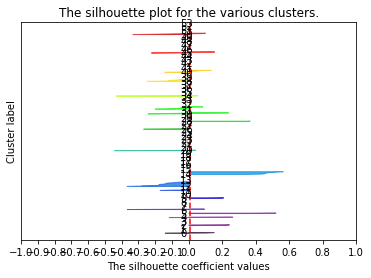

For n_clusters = 54 The average silhouette_score is : 0.010430176
Ya debio plotear


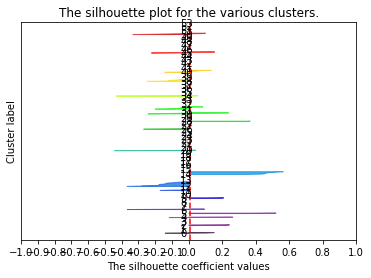

id: 15 of 61
cuda
0.066782385
test15
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.066782385
Ya debio plotear


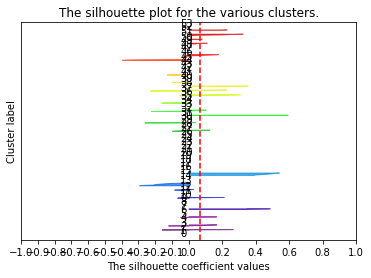

id: 16 of 61
cuda
0.09643592
test16
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.09643592
Ya debio plotear


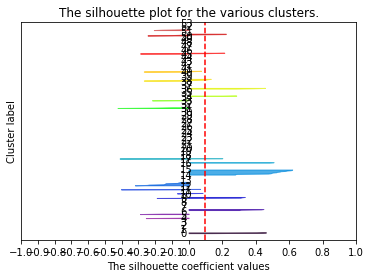

For n_clusters = 54 The average silhouette_score is : 0.09643592
Ya debio plotear


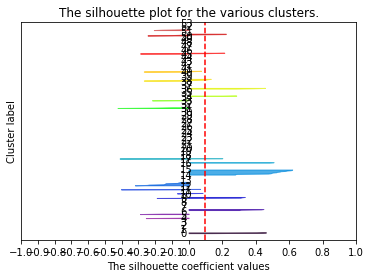

id: 17 of 61
cuda
0.038600646
test17
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.038600646
Ya debio plotear


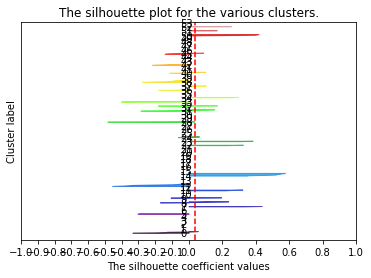

id: 18 of 61
cuda
-0.00059381465
test18
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : -0.00059381465
Ya debio plotear


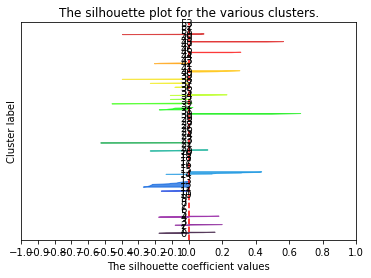

For n_clusters = 54 The average silhouette_score is : -0.00059381465
Ya debio plotear


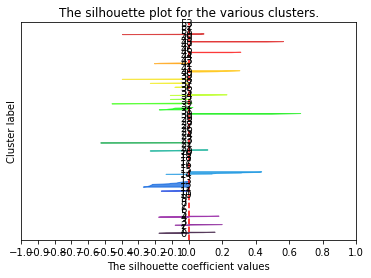

id: 19 of 61
cuda
0.045665856
test19
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.045665856
Ya debio plotear


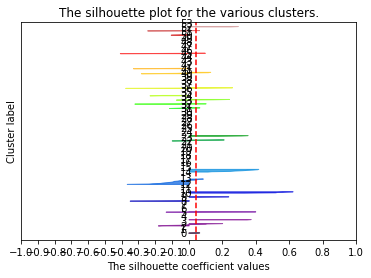

id: 20 of 61
cuda
0.05798502
test20
plotting silhouette graph
For n_clusters = 54 The average silhouette_score is : 0.05798502
Ya debio plotear


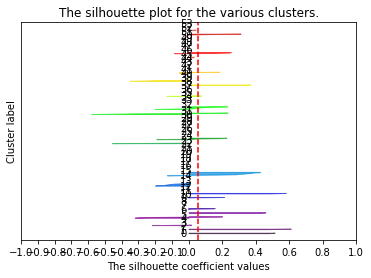

For n_clusters = 54 The average silhouette_score is : 0.05798502
Ya debio plotear


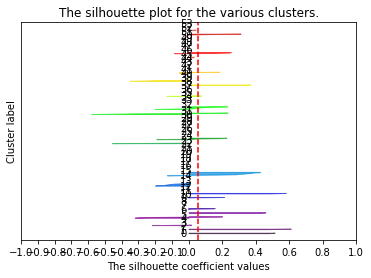

id: 21 of 61
cuda
0.042839047
test21
nothing to plot
For n_clusters = 54 The average silhouette_score is : 0.042839047
Ya debio plotear


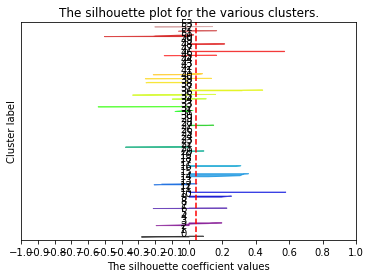

In [ ]:
iterator_Dataset = iter(training_loader)
testing = TestModel(model, iterator_Dataset, device=torch.device("cuda"))
Clustering = AE_Clustering(testing, training_loader, 54)
kmeans = Clustering.fordward()

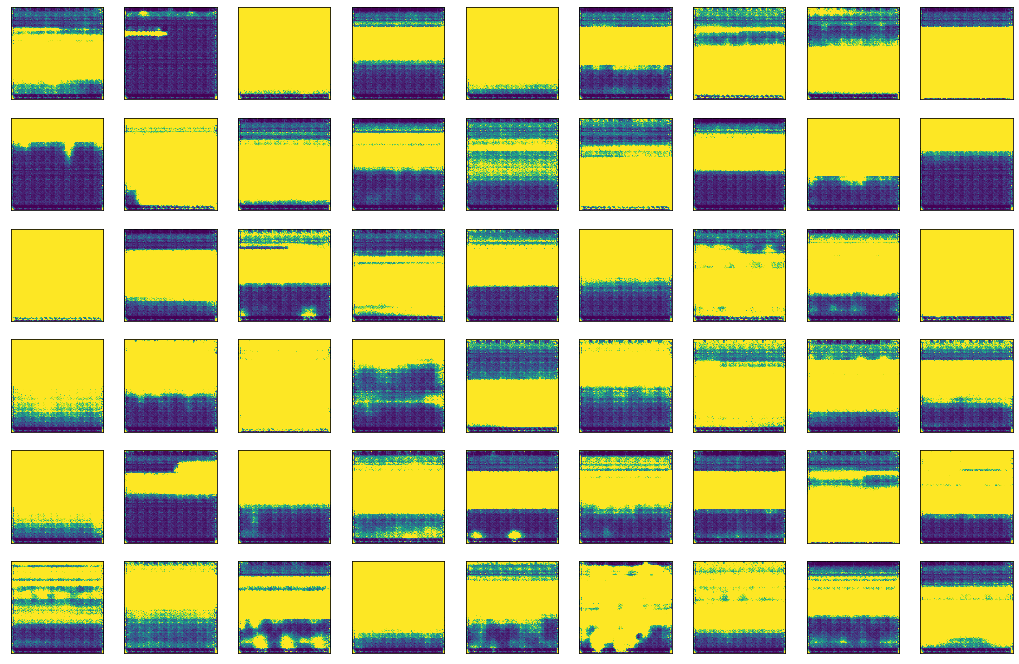

In [ ]:
Clustering.plot_centroids()

In [ ]:
encodings_size = [64,9,9]
plt.figure(figsize=(18, 18))
model.to("cpu")
for i, spec in enumerate(kmeans.cluster_centers_):
    encodings = spec.reshape(encodings_size)
    encodings = torch.tensor(encodings).float()
    decodings = model.decoder(encodings).detach().numpy()
    plt.subplot(9, 9, i + 1)
    plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
    plt.xticks(())
    plt.yticks(())


In [ ]:
from scipy.io.wavfile import write

class TestModel:

    def __init__(self, model, iterator, num_views):
        self._model = model
        self._iterator = iterator
        self.num_views = num_views
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_waveform(self, waveform, directory=None):
        scaled = np.int16(waveform[0,0]/np.max(np.abs(waveform[0,0])) * 32767)
        write(directory + '.wav', 22050, scaled)

    def plot_waveform(self, waveform, n_rows=4):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6), constrained_layout=True)
        for i in range(n_rows):
            axs[i].plot(waveform[i,0])               
        plt.show()
        
        
    def waveform_generator(self, spec, n_fft=1028, win_length=1028, audio_length=12, base_win=256):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        # hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform
    
    def plot_psd(self, waveform, n_wavs=1):
        for i in range(n_wavs):
            plt.psd(waveform[i][0])
            plt.xlabel("Frequency", fontsize=16)
            plt.ylabel("Power Spectral Density", fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)



    def plot_reconstructions(self, imgs_original, imgs_reconstruction, num_views:int = 8):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20,5))
        ax.imshow(img_grid[1,:,:].cpu(), vmin=0, vmax=0.02, origin = "lower")
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _, label) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                    valid_originals.shape[2], valid_originals.shape[3]))
        valid_originals = torch.unsqueeze(valid_originals,1)

        valid_originals = valid_originals.to(self.device)

        valid_encodings = self._model.encoder(valid_originals)

        valid_reconstructions = self._model.decoder(valid_encodings)

        valid_originals_nonorm = torch.expm1(valid_originals)
        valid_reconstructions_nonorm = torch.expm1(valid_reconstructions)

        BCE = F.mse_loss(valid_reconstructions, valid_originals)
        loss = BCE

        return valid_originals, valid_reconstructions, valid_encodings, label, loss

    def run(self, plot=True, wave_return=True, wave_plot=True, directory=None):
        wave_original = []
        wave_reconstruction = []
        originals, reconstructions, encodings, label, error = self.reconstruct() 
        if plot:
            self.plot_reconstructions(originals, reconstructions)
        if wave_return:
            wave_original = self.waveform_generator(originals)
            wave_reconstruction = self.waveform_generator(reconstructions)
            if wave_plot:
                self.plot_waveform(wave_original, n_rows=4)
                self.plot_waveform(wave_reconstruction, n_rows=4)
            if directory != None:
                dir_ori = directory+"original_"
                dir_recon = directory+"reconstruction_"
                self.save_waveform(wave_original, dir_ori)
                self.save_waveform(wave_reconsctruction, dir_recon)

        return originals, reconstructions, encodings, label, error


class TrainModel:

    def __init__(self, model):
        self._model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def wandb_init(self, config, keys=["audio_length", "win_length", "batch_size"]):
        try:
            run_name = "AE_"
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + ":" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project="AE-Jaguas", config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True         
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})


    def fordward(self, training_loader, test_loader, config):
        iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]

        train_res_recon_error = []
        train_res_perplexity = []
        logs = []
        best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    (data, _,_) = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
                data = torch.unsqueeze(data,1)
                data = data.to(self.device)

                optimizer.zero_grad()
                data_recon = self._model(data)

                loss = F.mse_loss(data_recon, data)
                loss.backward()

                optimizer.step()
                print(f'epoch: {epoch+1} of {config["num_epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(),4)}')
                dict = {"loss":loss.item()}
                self.wandb_logging(dict)
                                
                
                if (i+1) % 50 == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8)
                        #torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, encodings, labels, test_error = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions, 8)
                        images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
                        self.wandb_logging({"examples": images, "step": i+1//50})
                        
                    except Exception as e:
                        print("error")
                        logs.append(e)
                        continue
                else:
                    pass

                if loss < 0.05:
                    wandb.alert(
                    title='High accuracy',
                    text=f'Recon error {loss} is lower than 0.05',
                    level=AlertLevel.WARN,
                    wait_duration=timedelta(minutes=5)
                                )        
                    torch.save(self._model.state_dict(),f'{run_name}_low_error.pkl')
                else:
                    pass
            
            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(),f'{run_name}_epoch:{epoch+1}_{time.day}_{time.hour}.pkl')
            output.clear()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn import preprocessing

class AE_Clustering:

    def __init__(self, AE_testing, dataset, n_clusters:int = 27):
        self._ae_testing = AE_testing
        self._dataset = dataset
        self._n_clusters = n_clusters

    def labeling(self, label, repetitions:int = 4, axes:int = 0):
        le = preprocessing.LabelEncoder()
        labela = np.array(label)
        labels= np.repeat(label, repetitions, axes)
        le.fit(labels)
        labels = le.transform(labels)
        return labels

    def plot_clusters(self, X_embedded, original_labels, cluster_labels):
        plt.close("all")
        output.clear()
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(2,1,1) 
        ax.scatter(X_embedded[:,0], X_embedded[:,1],c=cluster_labels)
        ax = fig.add_subplot(2,1,2)
        ax.scatter(X_embedded[:,0], X_embedded[:,1],c=original_labels)
        plt.show() 

    def plot_centroids(self):
        plt.figure(figsize=(18, 18))
        self._ae_testing._model.to("cpu")
        for i, spec in enumerate(self.kmeans.cluster_centers_):
            encodings = spec.reshape(self._encodings_size)
            encodings = torch.tensor(encodings).float()
            decodings = self._ae_testing._model.decoder(encodings).detach().numpy()
            plt.subplot(9, 9, i + 1)
            plt.imshow(decodings[0,:,:], cmap="inferno", interpolation="nearest",vmin=0, vmax=0.02)
            plt.xticks(())
            plt.yticks(())

    def fordward(self):
        for id, item in enumerate(self._dataset):
            self._ae_testing._model.to("cuda")
            originals, reconstructions, encodings, label, loss = self._ae_testing.reconstruct()
            self._encodings_size = encodings[0].shape
            #label = label.to("cpu")
            labels = self.labeling(label, repetitions=4, axes=0)
            self.kmeans = MiniBatchKMeans(n_clusters=self._n_clusters, random_state=0)
            encodings = encodings.to("cpu").detach()
            encodings = encodings.reshape(216,
                                        encodings.shape[1]*encodings.shape[2]*encodings.shape[3])
            self.kmeans = self.kmeans.partial_fit(encodings)
            embedding = self.kmeans.transform(encodings)
            mbk_means_cluster_centers = self.kmeans.cluster_centers_
            # mbk_means_labels = pairwise_distances_argmin(encodings, mbk_means_cluster_centers)
            mbk_means_labels = self.kmeans.predict(encodings)
            X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(encodings)
            print(X_embedded.shape)
            self.plot_clusters(X_embedded, mbk_means_labels, labels)
        return self.kmeans

    
